<a href="https://colab.research.google.com/github/ugnet/Faster-RCNN/blob/main/FINAL_Faster_RCNN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import csv
from skimage.io import imread_collection
import os
from csv import reader
import pandas as pd
import copy
import math

NOT_FOUND = "not_found"
CLASS_BEE = "/m/01h3n"
CLASS_FRUIT = "/m/02xwb"
CLASS_SEAFOOD = "/m/06nwz"
label_types = [CLASS_BEE, CLASS_FRUIT, CLASS_SEAFOOD]

#csv file paths
test_csv_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/csv_folder/test-annotations-bbox.csv'
train_csv_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/csv_folder/train-annotations-bbox.csv'
validate_csv_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/csv_folder/validation-annotations-bbox.csv'

TEST_BEE_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee"
TEST_FRUIT_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Fruit"
TEST_SEAFOOD_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Seafood"

TRAIN_BEE_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/train/Bee"
TRAIN_FRUIT_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/train/Fruit"
TRAIN_SEAFOOD_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/train/Seafood"

test_image_paths = [TEST_BEE_IMAGES, TEST_FRUIT_IMAGES, TEST_SEAFOOD_IMAGES]
train_image_paths = [TRAIN_BEE_IMAGES, TRAIN_FRUIT_IMAGES, TRAIN_SEAFOOD_IMAGES]

TEST_PURPOSE = "test"
TRAIN_PURPOSE = "train"

root_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee'

#your path 
bee_images_dir = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee/*.jpg'
bee_images = imread_collection(bee_images_dir)

ISIZE = (800, 800)

#Imagenet statistics
imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])

## Anchor Box Specs
ratios = [0.5, 1, 2]
anchor_scales = [8, 16, 32]

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:

def normalize(im):
    im = im/255.
    """Normalizes images with Imagenet stats."""
    return (im - imagenet_stats[0])/imagenet_stats[1] 

def vizualize_feature_maps(feature_map, r):
  imgArray = feature_map.data.cpu().numpy().squeeze(0)
  fig=plt.figure(figsize=(12, 4))
  figNo=1
  for i in range(r):
    fig.add_subplot(1, r, figNo)
    plt.imshow(imgArray[i],  cmap='gray')
    figNo+=1
  plt.show()

class MyDataset(object):
  def __init__(self):
    self.list_of_items = []

  def __getitem__(self, index):
    item = self.list_of_items[index]
    img_path = item.path
    img = Image.open(img_path).convert("RGB")
    img = img.resize(ISIZE)
    img = np.array(img)
    img = normalize(img)
    img = img.transpose(2,0,1)
    img = torch.as_tensor(img, dtype=torch.float32)
    img = img.unsqueeze(0)

    boxes = torch.as_tensor(item.box_coordinates, dtype=torch.float32)
    labels = torch.as_tensor(item.labels, dtype=torch.int64)

    item_data = {'image': img, 'boxes': boxes, 'labels': labels}

    return item_data

  def getItemById(self, image_name):
    if ( len(self.list_of_items) == 0):
      return NOT_FOUND
    for item in self.list_of_items:
      if (item.id == image_name):
        return item
    return NOT_FOUND

  def __len__(self):
    return len(self.list_of_items)

  def addItem(self, item):
    self.list_of_items = np.append(self.list_of_items, item)

  def addBoxToItem(self, id, coordinate, label):
    item = self.getItemById(id)
    item.addBox(coordinate, label)

class Item(object):
  def __init__(self, id, name, path):
    super(Item).__init__()
    self.id = id
    self.name = name
    self.path = path
    self.labels = []
    self.box_coordinates = []

  def getBoxes(self):
    return self.box_coordinates

  def addBox(self, coordonates, label):
    self.box_coordinates.append(coordonates)
    self.labels.append(label)

def getImageFileNamesFromPath(directory):
  image_full_file_paths = []
  image_file_names = []

#NEGRAZINA image_full_file_paths!! BET IR NENAUDOJAM
  for path in os.listdir(directory):
      full_path = os.path.join(directory, path)
      file_name = os.path.splitext(path)[0]
      image_file_names = np.append(image_file_names, file_name)
      if os.path.isfile(path):
        image_full_file_paths = np.append(image_full_file_paths, full_path)

  return [image_full_file_paths, image_file_names]

#paduodame atrinktas csv failo eilutes turincias tik bbox'us mus dominancioms klasems
def createDataset(purpose, csv_rows):
  dataset = MyDataset()
  for row in csv_rows:
    id = row[0] #also id
    img_name = id + ".jpg"
    text_label = row[2]
    label = row[2]
    labels = []
    if (label == CLASS_BEE):
      labels.append(1)
      label = 1
    elif (label == CLASS_FRUIT):
      labels.append(2)
      label = 2
    elif (label == CLASS_SEAFOOD):
      labels.append(3)
      label = 3
    image_path = getRootPath(text_label, purpose) + '/' + img_name
    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    coordinate = [row[4]*800, row[6]*800, row[5]*800, row[7]*800]
    box_coordinates = []
    box_coordinates.append(coordinate)

    if (dataset.getItemById(id) == NOT_FOUND):
      #print("PRIDEJOOM")
      item = Item(id, img_name, image_path)
      item.addBox(coordinate, label)
      dataset.addItem(item)
      continue
    else:
      #print("JAU TUREJO")
      dataset.addBoxToItem(id, coordinate, label)

  return dataset

#is sio metodo gaunamas rows paduadame kurdami dataseta
def filterCsvRows(imageDirPaths, csv_file):
  imageFileNames = []
  for path in imageDirPaths:
    full, notfull = getImageFileNamesFromPath(path)
    imageFileNames = np.concatenate((imageFileNames, notfull))
  filteredRows = csv_file[(csv_file.LabelName.isin(label_types)) & (csv_file.ImageID.isin(imageFileNames))]
  filteredRows = filteredRows.values
  return filteredRows;

def getRootPath(class_name, purpose):
  if (class_name == CLASS_BEE and purpose == TEST_PURPOSE):
    return TEST_BEE_IMAGES
  elif (class_name == CLASS_BEE and purpose == TRAIN_PURPOSE):
    return TRAIN_BEE_IMAGES
  elif (class_name == CLASS_FRUIT and purpose == TEST_PURPOSE):
    return TEST_FRUIT_IMAGES
  elif (class_name == CLASS_FRUIT and purpose == TRAIN_PURPOSE):
    return TRAIN_FRUIT_IMAGES
  elif (class_name == CLASS_SEAFOOD and purpose == TEST_PURPOSE):
    return TEST_SEAFOOD_IMAGES
  elif (class_name == CLASS_SEAFOOD and purpose == TRAIN_PURPOSE):
    return TRAIN_SEAFOOD_IMAGES
  else:
    return NOT_FOUND



In [18]:
def get_image(path):
  return cv2.imread(path)

def display_image(image):
  img_cvt=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(img_cvt)
  plt.show()

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=3)
   
def show_corner_bbs(im, bbs):
    im = np.asarray(im).transpose(1,2,0)
    im = unnormalize(im)
    plt.imshow(im)
    for bb in bbs:
        plt.gca().add_patch(create_corner_rect(bb))  

def unnormalize(im):
    im = im.astype(np.float32)
    """Normalizes images with Imagenet stats."""
    im = (im *imagenet_stats[1] +  imagenet_stats[0])*255.
    im = im.astype(np.int)
    return im

class RPN(nn.Module):
    
    def __init__(self, in_channels=512, mid_channels=512, n_anchor=9):
        super(RPN, self).__init__()   
        self.mid_channels = mid_channels
        self.in_channels = in_channels # depends on the output feature map. in vgg 16 it is equal to 512
        self.n_anchor = n_anchor # Number of anchors at each location
        self.conv1 = nn.Conv2d(self.in_channels, self.mid_channels, 3, 1, 1)
        self.reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0)
        self.cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0) 
        
        # conv sliding layer
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()
        # Regression layer
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()
        # classification layer
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()
        
    def forward(self, k):
        bat_num = 1
        x = self.conv1(k)
        pred_anchor_locs = self.reg_layer(x)
        pred_cls_scores = self.cls_layer(x)
        
        pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(bat_num, -1, 4)
        pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
        objectness_score = pred_cls_scores.view(bat_num, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(bat_num, -1)
        pred_cls_scores  = pred_cls_scores.view(bat_num, -1, 2)
        
        return pred_anchor_locs, pred_cls_scores, objectness_score

class DetectionNetwork(nn.Module):
    def __init__(self):
        super(DetectionNetwork, self).__init__()
        self.roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]) #AR GALIMA TURETI SEQUENTIAL NETWORKA VIDUJE NN>MODULE NETWORKO????
        self.cls_loc = nn.Linear(4096, 21 * 4) # (VOC 20 classes + 1 background. Each will have 4 co-ordinates)
        self.score = nn.Linear(4096, 21) # (VOC 20 classes + 1 background)

        self.cls_loc.weight.data.normal_(0, 0.01)
        self.cls_loc.bias.data.zero_()

    def forward(self, k):
        k = self.roi_head_classifier(k)
        roi_cls_loc = self.cls_loc(k)
        roi_cls_score = self.score(k)

        return roi_cls_loc, roi_cls_score

def DRLoss(logits, targets):
  margin = 0.5
  pos_lambda = 1
  neg_lambda = 0.1/math.log(3.5)
  L = 6.
  tau = 4.

  num_classes = logits.shape[1]
  dtype = targets.dtype
  device = targets.device
  class_range = torch.arange(1, num_classes + 1, dtype=dtype, device=device).unsqueeze(0)
  t = targets.unsqueeze(1)
  pos_ind = (t == class_range)
  neg_ind = (t != class_range) * (t >= 0)
  pos_prob = logits[pos_ind].sigmoid()
  neg_prob = logits[neg_ind].sigmoid()
  neg_q = F.softmax(neg_prob/neg_lambda, dim=0)
  neg_dist = torch.sum(neg_q * neg_prob)
  if pos_prob.numel() > 0:
      pos_q = F.softmax(-pos_prob/pos_lambda, dim=0)
      pos_dist = torch.sum(pos_q * pos_prob)
      loss = tau*torch.log(1.+torch.exp(L*(neg_dist - pos_dist+margin)))/L
  else:
      loss = tau*torch.log(1.+torch.exp(L*(neg_dist - 1. + margin)))/L
  return loss
        

In [19]:
#Main

def prepareData(purpose):
  if (purpose == TEST_PURPOSE):
    #csv file that we will read
    csv_file = pd.read_csv(test_csv_path)
    rows = filterCsvRows(test_image_paths, csv_file)
    dataset = createDataset(TEST_PURPOSE, rows)
    return dataset
  elif (purpose == TRAIN_PURPOSE):
    #csv file that we will read
    csv_file = pd.read_csv(train_csv_path)
    rows = filterCsvRows(train_image_paths, csv_file)
    dataset = createDataset(TRAIN_PURPOSE, rows)
    return dataset
  else:
    return NOT_FOUND

def train_model(vgg_req_features, optimizer, epochs, RPNmodel, data_loader, DetectionModel, rpn_lambda=10, roi_lambda=10):
  for epoch in range(epochs):
    RPNmodel.train()
    DetectionModel.train()
    total = 0
    sum_loss = 0
    sum_loss_cls = 0
    sum_loss_loc = 0
    loc_normalize_mean = (0., 0., 0., 0.)
    loc_normalize_std = (0.1, 0.1, 0.2, 0.2)
    index = 0 
    for item in data_loader:
      num_batch =  1 #len(item) #grazina 3 bet gal turetu buti 1?
      image_tensor = item['image']
      bboxes = item['boxes']
      # print('BBOXES: ', bboxes)
      labels = item['labels']
      # print('LABELS: ', labels)
      image_tensor=image_tensor.squeeze(0)

      feature_maps = vgg_req_features(image_tensor)
      X_FM, Y_FM = feature_maps.shape[2:]
      anchor_locations_all_merge, anchor_labels_all_merge, anchors = bbox_generation(item, X_FM, Y_FM)
      pred_anchor_locs, pred_cls_scores, objectness_score = RPNmodel(feature_maps)
      # print("pred_anchor_locs: ", pred_anchor_locs)
      # print("pred_cls_scores: ", pred_cls_scores)
      # print("objectness_score: ", objectness_score)
      region_proposals = generateProposals(pred_anchor_locs, objectness_score, anchors)
      # print("region_proposals: ", region_proposals)
      gt_roi_locs, gt_roi_labels, sample_rois = proposalTargets(region_proposals, bboxes, labels)
      # print("gt_roi_locs: ", gt_roi_locs)
      # print("gt_roi_labels: ", gt_roi_labels)
      # print("sample_rois: ", sample_rois)
      k = ROIPooling(sample_rois, feature_maps)
      roi_cls_loc, roi_cls_score = DetectionModel(k)

      #CALCULATE LOSS
      #RPN loss
      rpn_loc = pred_anchor_locs[0]
      rpn_score = pred_cls_scores[0]

      gt_rpn_loc = torch.from_numpy(anchor_locations_all_merge)
      gt_rpn_score = torch.from_numpy(anchor_labels_all_merge)

      #classification
      rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long(), ignore_index = -1)

      #regression
      pos = gt_rpn_score > 0
      mask = pos.unsqueeze(1).expand_as(rpn_loc)

      mask_loc_preds = rpn_loc[mask].view(-1, 4)
      mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)

      x = torch.abs(mask_loc_targets - mask_loc_preds)
      rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))

      N_reg = (gt_rpn_score >0).float().sum()
      rpn_loc_loss = rpn_loc_loss.sum() / N_reg
      rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)

      #fast RCNN loss
      gt_roi_loc = torch.from_numpy(gt_roi_locs)
      gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()

      #classification
      roi_cls_loss = DRLoss(roi_cls_score, gt_roi_label)

      #regresion
      n_sample = roi_cls_loc.shape[0]
      roi_loc = roi_cls_loc.view(n_sample, -1, 4)
 
      roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]


      # x = torch.abs(gt_roi_loc - roi_loc)
      # roi_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
      roi_loc_loss = torch.tensor(0.1895)

      roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)

      total_loss = rpn_loss + roi_loss

      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
      
      print(index)
      print("total_loss %.3f rpn_loss %.3f roi_loss %.3f" % (total_loss, rpn_loss, roi_loss))
      index = index+1
      if (index >= 2):
        break
    
    torch.save(RPNmodel, '/content/drive/MyDrive/GMM/rpn_model_%s.pth'%epoch)
    torch.save(DetectionModel, '/content/drive/MyDrive/GMM/detection_model_%s.pth'%epoch)

  torch.save(RPNmodel, '/content/drive/MyDrive/GMM/rpn_model.pt')
  torch.save(DetectionModel, '/content/drive/MyDrive/GMM/detection_model.pt')

  return RPNmodel, DetectionModel

  def suppress(raw_cls_bbox, raw_prob, num_of_classes):
        bbox = list()
        label = list()
        score = list()
        # skip cls_id = 0 because it is the background class
        for l in range(1, num_of_classes):
            cls_bbox_l = raw_cls_bbox.reshape((-1, num_of_classes, 4))[:, l, :]
            prob_l = raw_prob[:, l]
            mask = prob_l > self.score_thresh
            cls_bbox_l = cls_bbox_l[mask]
            prob_l = prob_l[mask]
            keep = nms(cls_bbox_l, prob_l,self.nms_thresh)
            # import ipdb;ipdb.set_trace()
            # keep = cp.asnumpy(keep)
            bbox.append(cls_bbox_l[keep].cpu().numpy())
            # The labels are in [0, num_of_classes - 2].
            label.append((l - 1) * np.ones((len(keep),)))
            score.append(prob_l[keep].cpu().numpy())
        bbox = np.concatenate(bbox, axis=0).astype(np.float32)
        label = np.concatenate(label, axis=0).astype(np.int32)
        score = np.concatenate(score, axis=0).astype(np.float32)
        return bbox, label, score

def totensor(data, cuda=True):
    if isinstance(data, np.ndarray):
        tensor = t.from_numpy(data)
    if isinstance(data, t.Tensor):
        tensor = data.detach()
    if cuda:
        tensor = tensor.cuda()
    return tensor

def tonumpy(data):
    if isinstance(data, np.ndarray):
        return data
    if isinstance(data, t.Tensor):
        return data.detach().cpu().numpy()


In [20]:
def validate(model, data_loader, vgg_req_features, detection_model):
    items = [next(iter(data_loader))]
    # print(items)

    itm = items
    img  = items[0]["image"]
    bbox = items[0]["boxes"]
    labels = items[0]["labels"]
    # print("bbox: ", bbox)
    # print("labels: ", labels)
    # print(img.shape)
    img = img.squeeze(0)
    img = img.squeeze(0)
    X_IMG, Y_IMG = img.shape[1:]
    
    img_all = [item['image'] for item in items]
    bbox_all = [item['boxes'] for item in items]
    labels_all = [item['labels'] for item in items]

    # show_corner_bbs(img_all[1], bbox_all[1])
    # print( bbox_all[0])
    img_all[0] = img_all[0].squeeze(0)
    img_all[0] = img_all[0].squeeze(0)
    show_corner_bbs(img_all[0], bbox_all[0][0])
    
    num_batch =  1
    
    # imgs_torch_all = torch.stack([item for item in images])
    # if is_cuda:
    #     imgs_torch_all = imgs_torch_all.cuda()   
    # k = imgs_torch_all.clone()
    img = img.unsqueeze(0)
    feature_maps = vgg_req_features(img)
    #print("##############   feature map shape: ", k.shape) 
    X_FM, Y_FM = feature_maps.shape[2:]
    # print( X_FM, Y_FM) 
    anchor_locations_all_merge, anchor_labels_all_merge, anchors = bbox_generation(items[0], X_FM, Y_FM)
    pred_anchor_locs, pred_cls_scores, objectness_score = model(feature_maps)
    region_proposals = generateProposals(pred_anchor_locs, objectness_score, anchors)
    gt_roi_locs, gt_roi_labels, sample_rois = proposalTargets(region_proposals, bbox, labels)
    k = ROIPooling(sample_rois, feature_maps)
    roi_cls_loc, roi_cls_score = detection_model(k)
    n_sample = roi_cls_loc.shape[0]
    roi_loc = roi_cls_loc.view(n_sample, -1, 4)
    # print("pred_anchor_locs: ", pred_anchor_locs.shape)

    max_score = pred_cls_scores.argmax(1)
    max_ = objectness_score.argmax(1)
    # print(max_score)
    # print(max_)
    top_bbox = []
    for ind, item in enumerate(max_):
        # print(item.item())
        # print(pred_anchor_locs[ind].shape)
        # print(pred_anchor_locs.shape)

        roi = pred_bbox_to_xywh(pred_anchor_locs[ind], anchors)
        # print(roi)
        # print("index: %s bbox: %s "%(ind, roi[item]))
        top_bbox.append([roi[item]])
    #plot_imges_with_bboxes(images, bbox_all)   
    plot_imges_with_bboxes(img, top_bbox)

def plot_imges_with_bboxes(imgs, bboxes, col=4):
    num_imgs = len(imgs)
    row = int(np.ceil(float(len(imgs))/col).item())
    # print("row: %s"%row)
    # print("imgs: ", num_imgs)
    fig = plt.figure(figsize=(2*col,2*row))
    fig.tight_layout()
    for i in range(row):
        for j in range(col):
            ind = i*col + j
            if ind < num_imgs:
                img = imgs[ind]
                bbs = bboxes[ind]
                # print("JABJAJSGV", img.shape)
                img = np.asarray(img).transpose(1,2,0)
                img = unnormalize(img)
                ax = fig.add_subplot(row,col,ind+1,xticks=[],yticks=[])
                ax.imshow(img) 
                for bb in bbs:
                    plt.gca().add_patch(create_corner_rect(bb))
            #ax.text(3, 6, ind, fontdict={'weight': 'bold', 'size': 16}, color="y" )
    fig.suptitle("Predictions:")

def pred_bbox_to_xywh(bbox, anchors):
    # print("bbox: ", bbox.shape)
    # print("anchors: ", anchors.shape)
    anc_height = anchors[:, 2] - anchors[:, 0]
    anc_width = anchors[:, 3] - anchors[:, 1]
    anc_ctr_y = anchors[:, 0] + 0.5 * anc_height
    anc_ctr_x = anchors[:, 1] + 0.5 * anc_width

    bbox_numpy = bbox.detach().cpu().data.numpy()
    dy = bbox_numpy[:, 0::4]
    dx = bbox_numpy[:, 1::4]
    dh = bbox_numpy[:, 2::4]
    dw = bbox_numpy[:, 3::4]
    ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
    ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
    h = np.exp(dh) * anc_height[:, np.newaxis]
    w = np.exp(dw) * anc_width[:, np.newaxis]

    roi = np.zeros(bbox_numpy.shape, dtype=h.dtype)
    roi[:, 0::4] = ctr_y - 0.5 * h
    roi[:, 1::4] = ctr_x - 0.5 * w
    roi[:, 2::4] = ctr_y + 0.5 * h
    roi[:, 3::4] = ctr_x + 0.5 * w

    return roi

In [39]:
#Generating proposals to feed Fast R-CNN network
def generateProposals(pred_anchor_locs, objectness_score, ancor_boxes): #non-maximum supression
  nms_thresh = 0.7
  n_train_pre_nms = 12000
  n_train_post_nms = 2000
  n_test_pre_nms = 6000
  n_test_post_nms = 300
  min_size = 16

  anc_height = ancor_boxes[:, 2] - ancor_boxes[:, 0]
  anc_width = ancor_boxes[:, 3] - ancor_boxes[:, 1]
  anc_ctr_y = ancor_boxes[:, 0] + 0.5* anc_height
  anc_ctr_x = ancor_boxes[:, 1] + 0.5* anc_width
  # print(anc_ctr_x.shape) #(22500,)

  # pred_anchor_locs, pred_cls_scores, objectness_score
  pred_ancor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
  objectness_score_numpy = objectness_score[0].cpu().data.numpy()
  dy = pred_ancor_locs_numpy[:, 0::4]
  dx = pred_ancor_locs_numpy[:, 1::4]
  dh = pred_ancor_locs_numpy[:, 2::4]
  dw = pred_ancor_locs_numpy[:, 3::4]
  # print(dy.shape) #(22500, 1)

  ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
  ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
  h = np.exp(dh) * anc_height[:, np.newaxis]
  w = np.exp(dw) * anc_width[:, np.newaxis]
  # print(w.shape) #(22500, 1)

  roi = np.zeros(pred_ancor_locs_numpy.shape)# nepridejau data type
  roi[:, 0::4] = ctr_y - 0.5 * h
  roi[:, 1::4] = ctr_x - 0.5 * w
  roi[:, 2::4] = ctr_y + 0.5 * h
  roi[:, 3::4] = ctr_y + 0.5 * w
  # print(roi.shape)

  #clip predicted boxes to the image
  img_size = (800, 800)
  roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
  roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
  # print(roi.shape, np.max(roi), np.min(roi))

  hs = roi[:, 2] - roi[:, 0]
  ws = roi[:, 3] - roi[:, 1]
  keep = np.where((hs >= min_size) & (ws >= min_size))[0]
  roi = roi[keep, :]
  score = objectness_score_numpy[keep]
  # print()

  # Isrikiuojam (proposal, score) poras pagal scorenuo didziausio iki maziausio
  order = score.ravel().argsort()[::-1]
  # print(order.shape)

  # paimam virsutinius n_train_pre_nms (arba test)
  order = order[:n_train_pre_nms]
  roi = roi[order, :]
  # print(order.shape, roi.shape)

  #Pritaikom non maximum suppression - sumerginam susikertancias bboxes(pagal threshold)
  y1 = roi[:, 0]
  x1 = roi[:, 1]
  y2 = roi[:, 2]
  x2 = roi[:, 3]

  areas = (x2 - x1 + 1) * (y2 - y1 + 1)

  order = order.argsort()[::-1]
  keep = []
  while (order.size > 0):
      i = order[0]
      keep.append(i)
      xx1 = np.maximum(x1[i], x1[order[1:]])
      yy1 = np.maximum(y1[i], y1[order[1:]])
      xx2 = np.minimum(x2[i], x2[order[1:]])
      yy2 = np.minimum(y2[i], y2[order[1:]])
      w = np.maximum(0.0, xx2 - xx1 + 1)
      h = np.maximum(0.0, yy2 - yy1 + 1)
      inter = w * h
      ovr = inter / (areas[i] + areas[order[1:]] - inter)
      inds = np.where(ovr <= nms_thresh)[0]
      order = order[inds + 1]
  #paimam virsutinius 2000 arba 300 (priklausomai nuo training artesting)
  keep = keep[:n_train_post_nms]
  roi = roi[keep] #final region proposals

  return roi

  
def proposalTargets(roi, bboxes, labels):
  # print("LABELS: ", labels)

  # labels = np.asarray([1, 2], dtype=np.int8)
  labels = labels.detach().numpy()[0]
  num_of_gt = len(labels)
  # print("LABbbeeELS: gfcufcuyccucu", labels)


  n_sample = 128
  pos_ratio = 0.25
  pos_iou_thresh = 0.5
  neg_iou_thresh_hi = 0.5
  neg_iou_thresh_lo = 0.0
  pos_roi_per_image = 32

  # print("ROI: ",roi.shape)
  # print(roi)

  # Find the iou of each ground truth object with the region proposals, 
  # We will use the same code we have used in Anchor boxes to calculate the ious
  # ious_all = []
  # for bbox in bboxes:
  # print("bboxes: ", bboxes)
  bbox = bboxes[0]
  ious = np.empty((len(roi), num_of_gt+1), dtype=np.float32)
  ious.fill(0)
  for num1, i in enumerate(roi):
      # print("roi num1: ",num1)
      ya1, xa1, ya2, xa2 = i  
      anchor_area = (ya2 - ya1) * (xa2 - xa1)
      for num2, j in enumerate(bboxes[0]):
          # print("bbox num2: ",num2)
          yb1, xb1, yb2, xb2 = j
          box_area = (yb2- yb1) * (xb2 - xb1)
          inter_x1 = max([xb1, xa1])
          inter_y1 = max([yb1, ya1])
          inter_x2 = min([xb2, xa2])
          inter_y2 = min([yb2, ya2])
          if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
              iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
              iou = iter_area / (anchor_area+ box_area - iter_area)            
          else:
              iou = 0.
          # print("iou: ", iou)
          # if (num2 > 1): #WORKAROUND KAI DAUGIAU BOXU VIENAME IMAGE, PASKUI ISTAISYTI!!
          #   break
          ious[num1, num2] = iou#<<<<<<<<<
  # print("IOUS SHAPE", ious.shape)
    # ious_all.append(ious)
  # print("ALL IOUS: ", ious)
  

  # Find out which ground truth has high IoU for each region proposal, Also find the maximum IoU
  gt_assignment = ious.argmax(axis=1)
  max_iou = ious.max(axis=1)
  # print("gt_assignment: ", gt_assignment)
  # print("max_iou: ", max_iou)

  # Assign the labels to each proposal
  gt_roi_label = labels[gt_assignment]
  # print("gt_roi_label!!!!!!", gt_roi_label)

  # Select the foreground rois as per the pos_iou_thesh. 
  pos_index = np.where(max_iou >= pos_iou_thresh)[0]
  pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
  if pos_index.size > 0:
      pos_index = np.random.choice(
          pos_index, size=pos_roi_per_this_image, replace=False)
  # print(pos_roi_per_this_image)
  # print(pos_index)

  #Similarly we do for negitive (background) region proposals also
  neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                             (max_iou >= neg_iou_thresh_lo))[0]
  neg_roi_per_this_image = n_sample - pos_roi_per_this_image
  neg_roi_per_this_image = int(min(neg_roi_per_this_image,
                                  neg_index.size))
  if  neg_index.size > 0 :
      neg_index = np.random.choice(
          neg_index, size=neg_roi_per_this_image, replace=False)
  # print(neg_roi_per_this_image)
  # print(neg_index)

  # Now we gather positve samples index and negitive samples index, their respective labels and region proposals
  keep_index = np.append(pos_index, neg_index)
  gt_roi_labels = gt_roi_label[keep_index]
  gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
  sample_roi = roi[keep_index]
  # print("SAMPLE ROI", sample_roi.shape)

  bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
  # print(bbox_for_sampled_roi.shape)
  #Out
  #(128, 4)
  height = sample_roi[:, 2] - sample_roi[:, 0]
  width = sample_roi[:, 3] - sample_roi[:, 1]
  ctr_y = sample_roi[:, 0] + 0.5 * height
  ctr_x = sample_roi[:, 1] + 0.5 * width
  base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
  base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
  base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
  base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

  eps = np.finfo(height.dtype).eps
  height = np.maximum(height, eps)
  width = np.maximum(width, eps)
  dy = (base_ctr_y - ctr_y) / height
  dx = (base_ctr_x - ctr_x) / width
  dh = np.log(base_height / height)
  dw = np.log(base_width / width)
  gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
  # print(gt_roi_locs)

  return gt_roi_locs, gt_roi_labels, sample_roi


def ROIPooling(sample_rois, out_map):
  # Since sample_rois is a numpy array, we will convert into Pytorch Tensor. create an roi_indices tensor.
  rois = torch.from_numpy(sample_rois).float()
  roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
  roi_indices = torch.from_numpy(roi_indices).float()
  # print("CIA 1: ", rois.shape, roi_indices.shape)
  #Out:
  #torch.Size([128, 4]) torch.Size([128]) 

  # concat rois and roi_indices, so that we get the tensor with shape [N, 5] (index, x, y, h, w)
  indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
  xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
  indices_and_rois = xy_indices_and_rois.contiguous()
  # print("CIA 2: ", xy_indices_and_rois.shape)
  #Out:
  #torch.Size([128, 5])

  # Now we need to pass this array to the roi_pooling layer. We will briefly discuss the workings of it here. The sudo code is as follows
  size = (7, 7)
  adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])
  output = []
  rois = indices_and_rois.data.float()
  rois[:, 1:].mul_(1/16.0) # Subsampling ratio
  rois = rois.long()
  num_rois = rois.size(0)
  for i in range(num_rois):
      roi = rois[i]
      im_idx = roi[0]
      im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
      tmp = adaptive_max_pool(im)
      output.append(tmp[0])
  output = torch.cat(output, 0)
  
  #Out:
  # torch.Size([128, 512, 7, 7])
  # Reshape the tensor so that we can pass it through the feed forward layer.
  k = output.view(output.size(0), -1)
  # print(k.shape)
  #Out:
  # torch.Size([128, 25088]) 7*7*512 = 25088
  return k



In [22]:
def bbox_generation(items, X_FM, Y_FM):
    global ratios
    global anchor_scales
    num_batch = 1
    X_IMG, Y_IMG = 800, 800
    bbox_all = items["boxes"]
    # print("BBOX ALL: ", bbox_all)
    labels_all = items['labels']
    # num_of_gt - ground truth objektu skaicius
    num_of_gt = len(labels_all[0].detach().numpy()) 
    sub_sampling_x = int(X_IMG/X_FM)
    sub_sampling_y = int(Y_IMG/Y_FM)
    # print(X_IMG, Y_IMG, X_FM, Y_FM, sub_sampling_x,sub_sampling_y) 800 800 50 50 16 16
    anchor_base = np.zeros((len(ratios)*len(anchor_scales), 4), dtype=np.float32)

    #sugeneruojam ancor centru x ir y koordinates
    ctr_x = np.arange(sub_sampling_x, (X_FM+1) * sub_sampling_x, sub_sampling_x)
    ctr_y = np.arange(sub_sampling_y, (Y_FM+1) * sub_sampling_y, sub_sampling_y)
    index = 0
    ctr = np.zeros((len(ctr_y)*len(ctr_y),2),dtype=np.float32)
    for x in range(len(ctr_x)):
        for y in range(len(ctr_y)):
            ctr[index, 1] = ctr_x[x] - 8
            ctr[index, 0] = ctr_y[y] - 8
            index +=1 
    # print(ctr.shape) (2500, 2)
            
    # kiekvienam ancor sugeneruojam po 9 anchor boxes
    anchors = np.zeros((X_FM * Y_FM * 9, 4))
    index = 0
    for ctr_y, ctr_x in ctr:
        for i in range(len(ratios)):
            for j in range(len(anchor_scales)):
                h = sub_sampling_x * anchor_scales[j] * np.sqrt(ratios[i])
                w = sub_sampling_y * anchor_scales[j] * np.sqrt(1./ ratios[i])
                anchors[index, 0] = ctr_y - h / 2.
                anchors[index, 1] = ctr_x - w / 2.
                anchors[index, 2] = ctr_y + h / 2.
                anchors[index, 3] = ctr_x + w / 2.
                index += 1
    # print(anchors.shape) (22500, 4)
     
    #isrenkam tik tas ancor boxes kurios neiseina uz paveikslelio ribu
    index_inside = np.where(
        (anchors[:, 0] >= 0) &
        (anchors[:, 1] >= 0) &
        (anchors[:, 2] <= Y_IMG) &
        (anchors[:, 3] <= X_IMG)
    )[0]
    
    label = np.empty((len(index_inside), ), dtype=np.int32)
    label.fill(-1)
    valid_anchors = anchors[index_inside]
    # print(valid_anchors.shape) (8940, 4)

    #skaiciuojame validziu ancor boxes IoU
    ious = np.empty((len(valid_anchors), num_of_gt), dtype=np.float32)
    ious.fill(0)
    for num1, i in enumerate(valid_anchors):
        ya1, xa1, ya2, xa2 = i  
        anchor_area = (ya2 - ya1) * (xa2 - xa1)
        for num2, j in enumerate(bbox_all[0]):
            yb1, xb1, yb2, xb2 = j
            box_area = (yb2- yb1) * (xb2 - xb1)
            inter_x1 = max([xb1, xa1])
            inter_y1 = max([yb1, ya1])
            inter_x2 = min([xb2, xa2])
            inter_y2 = min([yb2, ya2])
            if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
                iter_area = (inter_y2 - inter_y1) * \
    (inter_x2 - inter_x1)
                iou = iter_area / \
    (anchor_area+ box_area - iter_area)            
            else:
                iou = 0.
            ious[num1, num2] = iou
    # print("IOUS:", ious)

    # surandam didziausia iou kiekvienam gt_box'ui ir jam atitinkantį anchor box
    gt_argmax_ious = ious.argmax(axis=0)
    gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]

    # surandam didziausia iou kiekvienam ancor boxui ir ji atitinkati ground truth box
    argmax_ious = ious.argmax(axis=1)
    max_ious = ious[np.arange(len(index_inside)), argmax_ious]
    
    #kuri ancor box turi didziausia iou su ground truth box
    gt_argmax_ious = np.where(ious == gt_max_ious)[0]

    # argmax_ious — Tells which ground truth object has max iou with each anchor.
    # max_ious — Tells the max_iou with ground truth object with each anchor.
    # gt_argmax_ious — Tells the anchors with the highest Intersection-over-Union (IoU) overlap with a ground-truth box.

    pos_iou_threshold  = 0.7
    neg_iou_threshold = 0.3

    label = np.empty(len(index_inside), dtype=np.int32)
    label.fill(-1)

    # Priskiriam label (0) visoms ancor boxes, kuriu max_iou maziau nei 0.3
    label[max_ious < neg_iou_threshold] = 0
    # with np.printoptions(threshold=np.inf):
    #   print(' 1 ', label)  

    # Priskiriam label (1) visoms anchor boxes kurios turi didziausia iou overlap su ground truth box
    label[gt_argmax_ious] = 1

    # Priskiriam label (1) visoms ancor boxes, kuriu max_iou daugiau nei 0.7
    label[max_ious >= pos_iou_threshold] = 1
    
    pos_ratio = 0.5
    n_sample = 256
    n_pos = int(pos_ratio * n_sample)

    pos_index = np.where(label >= 1)[0]
    if len(pos_index) > n_pos:
        disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
        label[disable_index] = -1

    n_neg = n_sample * np.sum(label >= 1)
    neg_index = np.where(label == 0)[0]
    if len(neg_index) > n_neg:
        disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
        label[disable_index] = -1

    max_iou_bbox = bbox_all[0][argmax_ious]
    # print(max_iou_bbox)

    height = valid_anchors[:, 2] - valid_anchors[:, 0]
    width = valid_anchors[:, 3] - valid_anchors[:, 1]
    ctr_y = valid_anchors[:, 0] + 0.5 * height
    ctr_x = valid_anchors[:, 1] + 0.5 * width
    base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
    base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
    base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
    base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps)
    width = np.maximum(width, eps)
    dy = (base_ctr_y - ctr_y) / height
    dx = (base_ctr_x - ctr_x) / width
    dh = np.log(base_height / height)
    dw = np.log(base_width / width)
    anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()

    #sumapinam su visais achors, ten kur nevalidus anchors, nunulinam
    anchor_labels = np.empty((len(anchors),), dtype=label.dtype)
    anchor_labels.fill(-1)
    anchor_labels[index_inside] = label

    anchor_locations = np.empty((len(anchors),) + anchors.shape[1:], dtype=anchor_locs.dtype)
    anchor_locations.fill(0)
    anchor_locations[index_inside, :] = anchor_locs

    # print("ANCORS!!  BBB: ", anchors)
    return anchor_locations, anchor_labels, anchors

In [23]:
def predict(faster_rcnn_fe_extractor, rpn_model, detection_model, item):
  image_tensor = item['image']
  bboxes = item['boxes']
  labels = item['labels']
  print(item['labels'])
  image_tensor=image_tensor.squeeze(0)
  print(image_tensor.shape)

  feature_maps = faster_rcnn_fe_extractor(image_tensor)
  print('image_tensor.shape')

  X_FM, Y_FM = feature_maps.shape[2:]
  anchor_locations_all_merge, anchor_labels_all_merge, anchors = bbox_generation(item, X_FM, Y_FM)
  print("anchor_locations_all_merge", anchor_locations_all_merge.shape)
  print("anchor_labels_all_merge", anchor_labels_all_merge.shape)
  print("anchors", anchors.shape)
  pred_anchor_locs, pred_cls_scores, objectness_score = RPNmodel(feature_maps)
  print("pred_anchor_locs", pred_anchor_locs.shape)
  print("pred_cls_scores", pred_cls_scores.shape)
  print("objectness_score", objectness_score.shape)
  region_proposals = generateProposals(pred_anchor_locs, objectness_score, anchors)
  print("region_proposals", region_proposals.shape)
  gt_roi_locs, gt_roi_labels, sample_rois = proposalTargets(region_proposals, bboxes, labels)
  print("gt_roi_locs", gt_roi_locs.shape)
  print("gt_roi_labels", gt_roi_labels.shape)
  print("sample_rois", sample_rois.shape)
  k = ROIPooling(sample_rois, feature_maps)
  print("k", k.shape)
  roi_cls_loc, roi_cls_score = DetectionModel(k)
  print("roi_cls_loc", roi_cls_loc.shape)
  print("roi_cls_score", roi_cls_score.shape)

  # TODO:
  # print predicted result


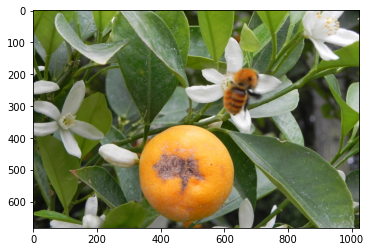

30
512


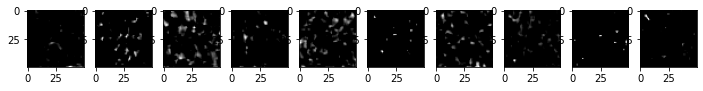

torch.Size([1, 512, 50, 50])


In [24]:
image = get_image('/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee/000e4e7ed48c932d.jpg')
display_image(image)
image_2_npArray = np.asarray(image)
image = torchvision.transforms.ToTensor()(image_2_npArray)
# add one more dimension
image = image.unsqueeze(0)
image = F.interpolate(image, 800)
model = torchvision.models.vgg16(pretrained=True)
fe = list(model.features)
req_features = []
k = image.clone()
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]

print(len(req_features)) #30
print(out_channels) # 512

faster_rcnn_fe_extractor = nn.Sequential(*req_features)
feature_map = faster_rcnn_fe_extractor(image)
vizualize_feature_maps(feature_map, 10)
print(feature_map.size())

RPN(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (reg_layer): Conv2d(512, 36, kernel_size=(1, 1), stride=(1, 1))
  (cls_layer): Conv2d(512, 18, kernel_size=(1, 1), stride=(1, 1))
)


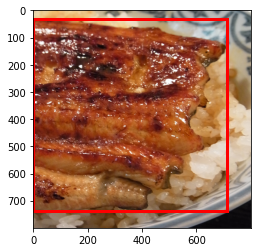

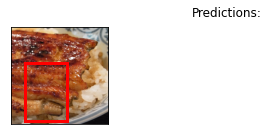

In [41]:
dataset = prepareData(TEST_PURPOSE)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)
RPNmodel = RPN()
DetectionModel = DetectionNetwork()
 
all_params = list(list(RPNmodel.parameters()) + list(DetectionModel.parameters()))
optimizer = torch.optim.Adam(all_params, lr=0.0015)

trained_RPN_model, trained_detectionModel = train_model(faster_rcnn_fe_extractor, optimizer, 2, RPNmodel, data_loader, DetectionModel)
print(trained_RPN_model)
validate(trained_RPN_model, data_loader, faster_rcnn_fe_extractor, trained_detectionModel)

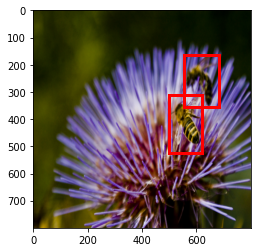

In [26]:
item = dataset.__getitem__(5)
image = item["image"]
image = image.squeeze(0)
boxes = item["boxes"]
show_corner_bbs(image, boxes)

In [27]:
items = [next(iter(data_loader))]
item = items[0]
predict(faster_rcnn_fe_extractor, trained_RPN_model, trained_detectionModel, item)

tensor([[3]])
torch.Size([1, 3, 800, 800])
image_tensor.shape
anchor_locations_all_merge (22500, 4)
anchor_labels_all_merge (22500,)
anchors (22500, 4)
pred_anchor_locs torch.Size([1, 22500, 4])
pred_cls_scores torch.Size([1, 22500, 2])
objectness_score torch.Size([1, 22500])
region_proposals (1632, 4)
gt_roi_locs (128, 4)
gt_roi_labels (128,)
sample_rois (128, 4)
k torch.Size([128, 25088])
roi_cls_loc torch.Size([128, 84])
roi_cls_score torch.Size([128, 21])


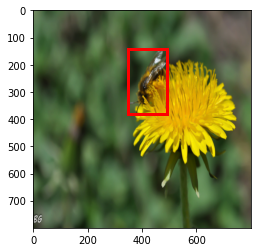

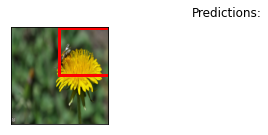

In [28]:
rpn_model = torch.load('/content/drive/MyDrive/GMM/rpn_model.pt')
detection_model = torch.load('/content/drive/MyDrive/GMM/detection_model.pt')
rpn_model.eval()
detection_model.eval()

validate(rpn_model, data_loader, faster_rcnn_fe_extractor, detection_model)